In [14]:
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))

import configparser
import logging
from functools import partial
from typing import OrderedDict

import numpy as np
from shapely import Polygon

from bbtoolkit.dynamics import DynamicsManager
from bbtoolkit.dynamics.callbacks.attention import AttentionCallback
from bbtoolkit.dynamics.callbacks.fov import EgoCallback, EgoSegmentationCallback, FOVCallback, ParietalWindowCallback
from bbtoolkit.dynamics.callbacks.movement import MovementCallback, MovementSchedulerCallback, TrajectoryCallback
from bbtoolkit.dynamics.callbacks.viz import AgentPlotter, PlottingCallback
from typing import Mapping
from bbtoolkit.models.bb.callbacks import FramesStoringCallback, TimerCallback
from bbtoolkit.models.bb.callbacks.memory import ObjectWeightsUpdatingCallback
from bbtoolkit.models.bb.callbacks.movement import MentalMovementCallback, MentalMovementSchedulerCallback, MentalPositionCallback, MentalTrajectoryCallback
from bbtoolkit.models.bb.callbacks.populations import BVCCallback, GCRateCallback, HDCallback, IPRateCallback, OVCCallback, PCCallback, PRCallback, PWCallback,\
    TCCallback, oPRCallback, oPWCallback, oTCCallback
from bbtoolkit.models.bb.callbacks.viz import AloEnvPlotter, BVCPlotter, DistanceAttentionPlotter, EgoEnvPlotter, HDPlotter, MentalAgentPlotter,\
    MentalTargetPlotter, MentalTrajectoryPlotter, MouseEventCallback, OVCPlotter, ObjectRecallCallback, PCPlotter, PWPlotter, PickedObjectPlotter,\
    TargetPlotter, TimerPlotter, TrajectoryPlotter, oPRPlotter, oPWPlotter
from bbtoolkit.models.bb.structures import BBCache, ClickParameters, DynamicParameters, EcodingParameters
from bbtoolkit.models.bb.utils import Grid2CartTransition, connectivity_config2dict, activity2rate
from bbtoolkit.models.bb.neural_generators import TCGenerator, GCMap

from bbtoolkit.utils.attention import DistanceAttention
from bbtoolkit.utils.movement import MovementManager
from bbtoolkit.utils.movement.trajectory import AStarTrajectory
from bbtoolkit.utils.datautils import Cached
from bbtoolkit.utils.datautils.configparser import EvalConfigParser
from bbtoolkit.utils.math import pol2cart
from bbtoolkit.utils.math.geometry import calculate_polar_distance, points2segments
from bbtoolkit.utils.viz.colors import generate_cmap

from bbtoolkit.environment import Environment
from bbtoolkit.environment.compilers import DynamicEnvironmentCompiler
from bbtoolkit.environment.compilers.callbacks import TransparentObjects
from bbtoolkit.environment.utils import env2builder
from bbtoolkit.environment.visible_planes import LazyVisiblePlaneWithTransparancy
from bbtoolkit.environment.fov import FOVManager
from bbtoolkit.environment.fov.ego import EgoManager

from bbtoolkit.structures.geometry import Texture, TexturedPolygon
from bbtoolkit.structures.tensorgroups import DirectedTensorGroup, dict2directed_tensor, DirectedTensor, TensorGroup, NamedTensor
from bbtoolkit.models.bb.neural_generators import AbstractGenerator, get_boundary_activations
from bbtoolkit.structures.geometry import Coordinates2D


In [28]:
hd_config_path = '../cfg/cells/hd_cells.ini'
hd_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
hd_config.read(hd_config_path)

mtl_config_path = '../cfg/cells/mtl_cells.ini'
mtl_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
mtl_config.read(mtl_config_path)

tr_config_path = '../cfg/cells/transformation_circuit.ini'
tr_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
tr_config.read(tr_config_path)

env_cfg = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
env_cfg.read('../cfg/envs/squared_room.ini')

space_cfg = mtl_config['Space']
h_res = space_cfg.eval('res')
r_max = space_cfg.eval('r_max')

mtl_grid_cfg = mtl_config['PolarGrid']
n_radial_points = mtl_grid_cfg.eval('n_radial_points')
polar_dist_res = mtl_grid_cfg.eval('polar_dist_res')
polar_ang_res = mtl_grid_cfg.eval('polar_ang_res', locals={'pi': np.pi})
h_sig = mtl_grid_cfg.eval('sigma_hill')

tr_space_cfg = tr_config['Space']
tr_res = tr_space_cfg.eval('tr_res', locals={'pi': np.pi})
res = tr_space_cfg.eval('res')

n_steps = tr_config['Training'].eval('n_steps')

hd_neurons_cfg = hd_config['Neurons']
sigma_angular = hd_neurons_cfg.eval('sigma', locals={'pi': np.pi})
n_hd = hd_neurons_cfg.eval('n_neurons')


training_rect_cfg = env_cfg['TrainingRectangle']
max_train_x = training_rect_cfg.eval('max_train_x')
min_train_x = training_rect_cfg.eval('min_train_x')
max_train_y = training_rect_cfg.eval('max_train_y')
min_train_y = training_rect_cfg.eval('min_train_y')

# env = Environment.load('../../../Downloads/Telegram Desktop/doellerlab_env (2).pkl')
# env = Environment.load('../data/envs/inserted_wall_environment.pkl')
env = Environment.load('../data/envs/square_environment.pkl')

tc_gen = TCGenerator(
    n_hd,
    tr_res,
    res,
    r_max,
    polar_dist_res,
    n_radial_points,
    polar_ang_res,
    sigma_angular
)

builder = env2builder(env)
cache_manager = Cached(cache_storage=OrderedDict(), max_size=10000)
compiler = DynamicEnvironmentCompiler(
    builder,
    partial(
        LazyVisiblePlaneWithTransparancy,
        cache_manager=cache_manager,
    ),
    callbacks=[TransparentObjects()]
)

compiler.add_object(
    TexturedPolygon(
        Polygon([
            (-5, -5),
            (-6, -5),
            (-6, -6),
            (-5, -6)
        ]),
        texture=Texture(
            id_=31,
            color='#ffd200',
            name='main_object'
        )
    ),
    TexturedPolygon(
        Polygon([
            (-7, -7),
            (-8, -7),
            (-8, -8),
            (-7, -8)
        ]),
        texture=Texture(
            id_=32,
            color='#ffd200',
            name='main_object'
        )
    ),
    TexturedPolygon(
        Polygon([
            (2, 2),
            (1, 2),
            (1, 1),
            (2, 1)
        ]),
        texture=Texture(
            id_=33,
            color='#ffd200',
            name='main_object'
        )
    ),
    TexturedPolygon(
        Polygon([
            (-2, 2),
            (-1, 2),
            (-1, 1),
            (-2, 1)
        ]),
        texture=Texture(
            id_=34,
            color='#ffd200',
            name='main_object'
        )
    ),
    TexturedPolygon(
        Polygon([
            (7, 7),
            (6, 7),
            (6, 6),
            (7, 6)
        ]),
        texture=Texture(
            id_=35,
            color='#ffd200',
            name='main_object'
        )
    )
)

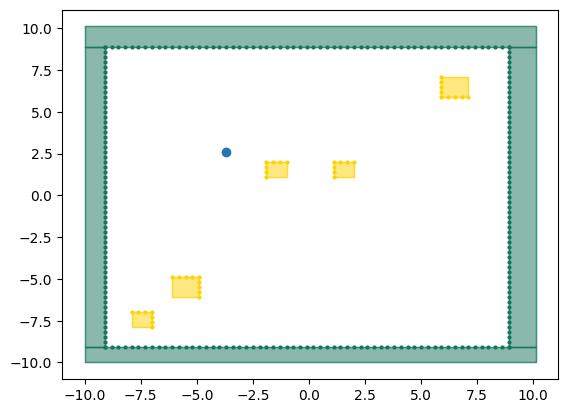

In [29]:
from bbtoolkit.utils.viz import plot_polygon
import matplotlib.pyplot as plt

%matplotlib inline
fig, ax = plt.subplots()
position = 1000 # the position of the agent (visible area has dimensionality n_positions x 2)
env = compiler.environment
for i, obj in enumerate(env.objects + env.walls):
    plot_polygon(obj.polygon, ax=ax, alpha=0.5, linewidth=1)
    ax.plot(
        obj.visible_parts[position, :, 0],
        obj.visible_parts[position, :, 1],
        'o',
        color=obj.polygon.texture.color,
        markersize=2
    )

ax.plot(
    env.params.coords[position, 0],
    env.params.coords[position, 1],
    'o'
)

In [30]:
config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
config.read('../cfg/connectivity/main.ini')

configdict = connectivity_config2dict(config)
connections = dict2directed_tensor(configdict)
connectivity = DirectedTensorGroup(*connections)

position = 1, -5
# direction = -np.pi/2
direction = 0
# fov_angle = 2*np.pi*.9
fov_angle = np.pi*.9
fov_manager = FOVManager(compiler.environment, fov_angle)
ego_manager = EgoManager(fov_manager)

cache = {'env': compiler.environment, 'tc_gen': tc_gen}
dt = 0.01
n_objects = len(compiler.environment.objects)

polar_distance = calculate_polar_distance(tc_gen.r_max)
polar_angle = np.linspace(0, (tc_gen.n_bvc_theta + 1) * tc_gen.polar_ang_res, tc_gen.n_bvc_theta)
polar_distance, polar_angle = np.meshgrid(polar_distance, polar_angle)
pdist, pang = polar_distance, polar_angle
x_bvc, y_bvc = pol2cart(pdist, pang)
hd_polar_res = 2 * np.pi / n_hd
hd_angles = np.arange(0, 2 * np.pi+ hd_polar_res, hd_polar_res) + np.pi/2
hd_dist, hd_ang = np.meshgrid(np.array([1, 1.5]), hd_angles)
hd_x, hd_y = pol2cart(hd_dist, hd_ang)

In [31]:
# mtl_weights = DirectedTensorGroup.load('../../../Downloads/Telegram Desktop/mtl_weights (5).pkl')
# tc_weights = DirectedTensorGroup.load('../../../Downloads/Telegram Desktop/tc_weights (2).pkl')
# hd_weights = DirectedTensorGroup.load('../../../Downloads/Telegram Desktop/hd_weights (2).pkl')
# pc_weights = DirectedTensorGroup.load('../../../Downloads/Telegram Desktop/pc_weights (2).pkl')
# gc_map = GCMap.load('../../../Downloads/Telegram Desktop/gc_map (2).pkl')

# mtl_weights = DirectedTensorGroup.load('../data/weights/mtl_weights_inserted_wall.pkl')
# mtl_weights = DirectedTensorGroup.load('../data/weights/mtl_weights_inserted_wall+half_pi.pkl')
# tc_weights = DirectedTensorGroup.load('../data/weights/tc_weights_inserted_wall.pkl')
# hd_weights = DirectedTensorGroup.load('../data/weights/hd_weights_inserted_wall.pkl')
# pc_weights = DirectedTensorGroup.load('../data/weights/pc_weights_inserted_wall.pkl')
# gc_map = GCMap.load('../data/weights/gc_map_inserted_wall.pkl')

mtl_weights = DirectedTensorGroup.load('../data/weights/mtl_weights_square.pkl')
tc_weights = DirectedTensorGroup.load('../data/weights/tc_weights_square.pkl')
hd_weights = DirectedTensorGroup.load('../data/weights/hd_weights_square.pkl')
pc_weights = DirectedTensorGroup.load('../data/weights/pc_weights_square.pkl')
gc_map = GCMap.load('../data/weights/gc_map_square.pkl')

weights = mtl_weights + tc_weights + hd_weights + pc_weights

n_h_neurons = len(weights.h.to.h)
n_bvc_neurons = n_opw_neurons = n_ovc_neurons = len(weights.bvc.to.bvc)
n_pr_neurons = len(weights.pr.to.pr)
n_hd_neurons = len(weights.hd.to.hd)
n_pc_neurons = len(weights.gc.to.h)
n_gc_neurons = len(weights.gc.to.h.T)
n_tc_layers = len(weights.tr.to.pw.T)

tr_projection = DirectedTensorGroup(
    DirectedTensor(
        from_='bvc',
        to='tr',
        weights=np.eye(n_bvc_neurons)
    ),
    DirectedTensor(
        from_='tr',
        to='bvc',
        weights=np.eye(n_bvc_neurons)
    )
)

new_pathways = DirectedTensorGroup(
    DirectedTensor(
        from_='h',
        to='opr',
        weights=np.zeros((n_objects, n_h_neurons))
    ),
    DirectedTensor(
        from_='opr',
        to='h',
        weights=np.zeros((n_h_neurons, n_objects))
    ),
    DirectedTensor(
        from_='h',
        to='ovc',
        weights=np.zeros((n_ovc_neurons, n_h_neurons))
    ),
    DirectedTensor(
        from_='ovc',
        to='h',
        weights=np.zeros((n_h_neurons, n_ovc_neurons))
    ),
    DirectedTensor(
        from_='ovc',
        to='ovc',
        weights=np.zeros((n_ovc_neurons, n_ovc_neurons))
    ),
    DirectedTensor(
        from_='bvc',
        to='ovc',
        weights=np.zeros((n_ovc_neurons, n_bvc_neurons))
    ),
    DirectedTensor(
        from_='ovc',
        to='bvc',
        weights=np.zeros((n_bvc_neurons, n_ovc_neurons))
    ),
    DirectedTensor(
        from_='opw',
        to='opw',
        weights=np.zeros((n_opw_neurons, n_opw_neurons))
    ),
    DirectedTensor(
        from_='ovc',
        to='opr',
        weights=np.zeros((n_objects, n_ovc_neurons))
    ),
    DirectedTensor(
        from_='opr',
        to='ovc',
        weights=np.zeros((n_ovc_neurons, n_objects))
    ),
    DirectedTensor(
        from_='opr',
        to='pw',
        weights=np.zeros((n_opw_neurons, n_objects))
    ),
    DirectedTensor(
        from_='opr',
        to='hd',
        weights=np.zeros((n_hd_neurons, n_objects))
    ),
    DirectedTensor(
        from_='bvc',
        to='opr',
        weights=np.zeros((n_objects, n_bvc_neurons))
    ),
    DirectedTensor(
        from_='opr',
        to='bvc',
        weights=np.zeros((n_bvc_neurons, n_objects))
    ),
    DirectedTensor(
        from_='opr',
        to='opr',
        weights=np.zeros((n_objects, n_objects))
    ),
)

weights += tr_projection
weights += new_pathways

weights = weights.operation_with(connectivity, lambda a, b: a - b.get('inhibitory_phi', 0), on_missing_weights='ignore', on_missing_sources='ignore')

In [32]:
activity = TensorGroup(
    NamedTensor('h', np.zeros((n_h_neurons, 1))),
    NamedTensor('bvc', np.zeros((n_bvc_neurons, 1))),
    NamedTensor('pr', np.zeros((n_pr_neurons, 1))),
    NamedTensor('pw', np.zeros((n_bvc_neurons, 1))),
    NamedTensor('hd', np.zeros((n_hd_neurons, 1))),
    NamedTensor('ovc', np.zeros((n_ovc_neurons, 1))),
    NamedTensor('opw', np.zeros((n_opw_neurons, 1))),
    NamedTensor('opr', np.zeros((n_objects, 1))),
    NamedTensor('tr', np.zeros((n_tc_layers, n_bvc_neurons, 1))),
    NamedTensor('otr', np.zeros((n_tc_layers, n_bvc_neurons, 1)))
)

walls_ego, objects_ego = ego_manager(position, direction)
wall_segments = np.concatenate([points2segments(wall) for wall in walls_ego if wall.size])
ego_input_walls = tc_gen.get_grid_activity(wall_segments)
hd_cue_init = 40*tc_gen.get_hd_activity(np.array([direction]))
hd_cue = np.zeros_like(hd_cue_init)
ohd_cue = hd_cue.copy()
pr_cue = np.zeros((n_pr_neurons, 1))

k_ratio = TensorGroup(
    NamedTensor('h', np.zeros((n_h_neurons, 1))),
    NamedTensor('bvc', np.zeros((n_bvc_neurons, 1))),
    NamedTensor('pr', np.zeros((n_pr_neurons, 1))),
    NamedTensor('opr', np.zeros((n_objects, 1))),
    NamedTensor('hd', np.zeros((n_hd_neurons, 1))),
    NamedTensor('pw', np.expand_dims(40*ego_input_walls, 1)), # FIXME: why 40?
    NamedTensor('ovc', np.zeros((n_ovc_neurons, 1))),
    NamedTensor('opw', np.zeros((n_opw_neurons, 1))),
    NamedTensor('tr', np.zeros((n_tc_layers, n_bvc_neurons, 1))),
    NamedTensor('otr', np.zeros((n_tc_layers, n_bvc_neurons, 1))),
)

activity.pw += dt/connectivity.pw.to.pw['tau']*k_ratio.pw

In [33]:
rates = activity2rate(activity, connectivity)
rates.add_tensor(NamedTensor('gc', np.array([])))
rates.add_tensor(NamedTensor('ip', np.array([])))

In [34]:
red = '#b20000'
green = '#00b2b2'
cmap = generate_cmap(*[
    green,
    '#fff',
    red
])

In [35]:
from bbtoolkit.dynamics.callbacks import BaseCallback


class PCCallback(BaseCallback):
    def __init__(self, i_comp: float = 0, i_comp_scale: float = 15):
        super().__init__()
        self.i_comp = i_comp
        self.i_comp_scale = i_comp_scale

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        cache['rates'].add_tensor(NamedTensor('i_comp', np.array([self.i_comp]).astype(float)))
        self.requires = [
            'dynamics_params',
            'k_ratio',
            'activity',
            'connectivity',
            'weights',
            'rates',
            'grid2cart'
        ]
        super().set_cache(cache, on_repeat)
        self.dt = self.dynamics_params['dt']

    def on_step_begin(self, step: int):
        self.cache['k_ratio'].h = (
            - self.activity.h
            + self.connectivity.h.to.h['phi']*self.weights.h.to.h@self.rates.h
            # + self.connectivity.pr.to.h['phi']*self.weights.pr.to.h@self.rates.pr
            # + self.connectivity.ovc.to.h['phi']*self.weights.ovc.to.h@self.rates.ovc
            + self.rates.i_comp
        )
        match self.dynamics_params['mode']:
            case 'bottom-up':
                self.cache['k_ratio'].h += self.connectivity.bvc.to.h['phi']*self.weights.bvc.to.h@self.rates.bvc

        self.activity.h += self.dt/self.connectivity.h.to.h['tau']*self.cache['k_ratio'].h
        self.rates.h = 1/(1 + np.exp(-2*self.connectivity.h.to.h['beta']*(self.activity.h - self.connectivity.h.to.h['alpha'])))
        self.rates.i_comp += self.dt/self.connectivity.ic.to.ic['tau']*(self.i_comp_scale - np.sum(self.rates.h))


In [36]:

class PCCallback(BaseCallback):
    """
    A callback designed to update place cell (PC) dynamics in an agent-based learning simulation.

    This callback computes the activity and rates of place cells based on various inputs and connectivity parameters, adjusting for intrinsic competition among cells.

    Attributes:
        i_comp (float): The initial value for inhibitory compencation.
        i_comp_scale (float): The addictive scaling factor for inhibitory compencation adjustment.
    """
    def __init__(self, i_comp: float = 0, i_comp_scale: float = 15):
        """
        Initializes the PCCallback instance with specified parameters for intrinsic competition.

        Args:
            i_comp (float): The initial value for inhibitory compencation.
            i_comp_scale (float): The scaling factor for inhibitory compencation adjustment.
        """
        super().__init__()
        self.i_comp = i_comp
        self.i_comp_scale = i_comp_scale

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        """
        Sets the cache with the provided mapping, adds a tensor for intrinsic competition, and specifies the required cache keys for PC dynamics update.

        Args:
            cache (Mapping): The new cache mapping.
            on_repeat (str): The behavior when a cache key is already an attribute. Defaults to 'raise'.

        Notes:
            The `self.requires` attribute specifies the following required parameters:
            - `dynamics_params`: Contains dynamic parameters of the simulation, including the current mode (e.g., 'bottom-up', 'top-down', 'recall').
            - `k_ratio`: Ratio of excitation/inhibition for PC cells.
            - `activity`: Neural activity levels.
            - `connectivity`: Connectivity matrices between neural populations.
            - `weights`: Synaptic weights between neurons.
            - `rates`: Firing rates of neurons.
            - `grid2cart`: A mapping function or structure to convert grid indices to Cartesian coordinates.
        """
        cache['rates'].add_tensor(NamedTensor('i_comp', np.array([self.i_comp]).astype(float)))
        self.requires = [
            'dynamics_params',
            'k_ratio',
            'activity',
            'connectivity',
            'weights',
            'rates',
            'grid2cart'
        ]
        super().set_cache(cache, on_repeat)
        self.dt = self.dynamics_params['dt']

    def on_step_begin(self, step: int):
        """
        Updates the activity and rates of place cells at the beginning of each simulation step, based on the current mode of operation and intrinsic competition among cells.

        Args:
            step (int): The current step number.
        """
        self.cache['k_ratio'].h = (
            - self.activity.h
            + self.connectivity.h.to.h['phi']*self.weights.h.to.h@self.rates.h
            + self.connectivity.pr.to.h['phi']*self.weights.pr.to.h@self.rates.pr
            + self.connectivity.ovc.to.h['phi']*self.weights.ovc.to.h@self.rates.ovc
            + self.rates.i_comp
        )
        match self.dynamics_params['mode']:
            case 'bottom-up':
                self.cache['k_ratio'].h += self.connectivity.bvc.to.h['phi']*self.weights.bvc.to.h@self.rates.bvc
            case 'recall':
                self.cache['k_ratio'].h += self.connectivity.opr.to.h['phi']*self.weights.opr.to.h@self.rates.opr
            case 'top-down':
                self.cache['k_ratio'].h += self.connectivity.opr.to.h['phi']*self.weights.opr.to.h@self.rates.opr +\
                    self.connectivity.gc.to.h['phi']*self.weights.gc.to.h@self.rates.gc

        self.activity.h += self.dt/self.connectivity.h.to.h['tau']*self.cache['k_ratio'].h
        self.rates.h = 1/(1 + np.exp(-2*self.connectivity.h.to.h['beta']*(self.activity.h - self.connectivity.h.to.h['alpha'])))
        self.rates.i_comp += self.dt/self.connectivity.ic.to.ic['tau']*(self.i_comp_scale - np.sum(self.rates.h))



In [37]:
from bbtoolkit.dynamics.callbacks.viz import ArtistCallback


class DebugArtist(ArtistCallback):
    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        self.requires = [
            'fig',
            'gc',
            'rates',
            'activity',
            'debug_ax1',
            'weights',
            'grid2cart',
            'movement_params',
            'encoding_params',
        ]
        cache['debug_ax1'] = cache['fig'].add_subplot(cache['gc'][8:12, 4:8])
        cache['fig'].tight_layout()
        super().set_cache(cache, on_repeat=on_repeat)

    def on_plot(self):
        # self.debug_ax1.imshow(self.weights.ovc.to.opr, aspect='auto', origin='lower')
        # self.debug_ax1.imshow(
        #     np.reshape(
        #         (self.weights.gc.to.h@self.rates.gc),
        #         self.grid2cart.shape
        #     ),
        #     cmap='coolwarm',
        # )
        # self.debug_ax1.plot(self.activity.hd)
        self.debug_ax1.imshow(
            (self.weights.bvc.to.h@self.cache['rates'].bvc).reshape(58, 58).T,
            origin='lower'
        )

    def on_clean(self):
        self.debug_ax1.clear()

In [38]:
import matplotlib.colors as mcolors

class PCPlotter(ArtistCallback):
    """
    A specialized ArtistCallback for plotting Place Cell (PC) activations in an agent-based learning simulation.

    This callback visualizes the agent's PC activations, providing insights into the agent's spatial location and cognitive map of the environment.

    Attributes:
        shape (tuple): The shape of the grid to which PC activations are mapped.
    """
    def __init__(self, cmap: str | mcolors.Colormap = 'coolwarm'):
        """
        Initializes the PCPlotter instance.

        Args:
            cmap (str | mcolors.Colormap, optional): The colormap for PC activations. Defaults to 'coolwarm'.
        """
        self.shape = None
        self.cmap = cmap
        super().__init__()

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        """
        Sets the cache with the provided mapping, initializes the plotting axis for PC representation, and specifies the required cache keys for plotting.

        Args:
            cache (Mapping): The new cache mapping.
            on_repeat (str): The behavior when a cache key is already an attribute. Defaults to 'raise'.
        """
        cache['gc_ax'] = cache.fig.add_subplot(cache.gc[8:, :4])
        self.requires = [
            'gc_ax',
            'rates',
            'grid2cart'
        ]
        super().set_cache(cache, on_repeat)
        self.shape = self.cache.grid2cart.shape[0], self.cache.grid2cart.shape[1]

    def plot(self):
        """
        Plots the PC activations using an image plot to visualize the agent's spatial location within the environment.
        """
        self.gc_ax.imshow(
            np.reshape(self.rates.h, self.shape).T,
            origin='lower',
            cmap=self.cmap,
            vmin=0, vmax=1,
        )

    def on_plot(self):
        """
        Executes the plotting logic for the PC activations.
        """
        self.plot()

    def on_clean(self):
        """
        Clears the plot in preparation for the next update and sets up the axis for better readability.
        """
        self.gc_ax.clear()
        self.gc_ax.set_axis_off()

In [39]:
%matplotlib qt

logging.getLogger('matplotlib').setLevel(logging.WARNING)

dt = .005

position = (7, -7)
direction = np.pi/2
attn_dist = 7.5

connectivity2use = connectivity.copy()
connectivity2use.h.to.h['phi'] = 4
# connectivity2use.pr.to.h['phi'] = 0
# connectivity2use.ovc.to.h['phi'] = 0
# connectivity2use.bvc.to.h['phi'] = 1000


weights2use = weights.copy()
# weights2use.bvc.to.h = bvc2h

cache = BBCache(
    connectivity2use,
    weights2use,
    k_ratio.copy(),
    activity.copy(),
    rates.copy(),
    tc_gen,
    compiler.environment,
    Grid2CartTransition(compiler.environment),
    DynamicParameters(dt, 'bottom-up'),
    EcodingParameters(),
    ClickParameters()
)

cache['weights'].tr.to.bvc = np.eye(len(weights.tr.to.bvc))
cache['weights'].bvc.to.tr = np.eye(len(weights.tr.to.bvc))

dynamics = DynamicsManager(
    dt,
    callbacks=[
        TimerCallback(),
        MovementCallback(
            MovementManager(
                5,
                np.pi*2,
                position,
                direction
            )
        ),
        MentalPositionCallback(),
        MentalMovementCallback(
            MovementManager(
                5,
                np.pi*2,
                position,
                direction
            )
        ),
        FOVCallback(fov_manager),
        EgoCallback(ego_manager),
        EgoSegmentationCallback(),
        ParietalWindowCallback(),
        MovementSchedulerCallback(),
        TrajectoryCallback(
            AStarTrajectory(compiler.environment)
        ),
        MentalMovementSchedulerCallback(),
        MentalTrajectoryCallback(
            AStarTrajectory(compiler.environment)
        ),
        AttentionCallback(
            DistanceAttention(7, dt, len(compiler.environment.objects), attn_dist)
        ),
        HDCallback(),
        GCRateCallback(gc_map),
        PCCallback(),
        BVCCallback(),
        OVCCallback(),
        PRCallback(),
        oPRCallback(),
        PWCallback(),
        oPWCallback(),
        IPRateCallback(),
        TCCallback(),
        oTCCallback(),
        ObjectWeightsUpdatingCallback(),
        PlottingCallback(
            [
                AloEnvPlotter(
                    attn_color=red
                ),
                EgoEnvPlotter(
                    attn_color=red
                ),
                MouseEventCallback(),
                TimerPlotter(),
                AgentPlotter(),
                TargetPlotter(
                    move_target_color=red
                ),
                TrajectoryPlotter(
                    target_color=red
                ),
                PWPlotter(cmap=cmap),
                BVCPlotter(cmap=cmap),
                oPWPlotter(cmap=cmap),
                OVCPlotter(cmap=cmap),
                # HDPlotter(cmap=cmap),
                PCPlotter(cmap=cmap),
                # oPRPlotter(
                #     '#00b2b2',
                #     '#b20000'
                # ),
                DebugArtist(),
                ObjectRecallCallback(),
                PickedObjectPlotter(),
                DistanceAttentionPlotter(attn_dist, color=red),
                MentalAgentPlotter(),
                MentalTargetPlotter(),
                MentalTrajectoryPlotter()
            ],
            update_rate=5,
            fig_kwargs=dict(figsize=(10, 10)),
            gc_kwargs=dict(nrows=12, ncols=12)
        ),
        FramesStoringCallback(5, '../tmp')
    ],
    cache=cache
)


for _ in dynamics(True):
    print('out: ', _)

out:  (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
out:  (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
out:  (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)


KeyboardInterrupt: 

In [ ]:
for _ in dynamics(True):
    print('out: ', _)

KeyboardInterrupt: 

In [ ]:
cache.movement_params.position

(-1.5553189843254436, -4.863684419513674)

In [ ]:
cache.grid2cart(*cache.movement_params.position)

(45, 24)

In [ ]:
plt.imshow(weights.h.to.bvc)

In [ ]:
from bbtoolkit.utils.viz.video import make_video_from_images


image_directory = '../tmp'
video_save_path = '../data/videos/debug_h_inserted(8).mp4'
make_video_from_images(image_directory, video_save_path, 2)

In [ ]:

from bbtoolkit.utils.datautils import remove_files_from_dir

remove_files_from_dir('../tmp')

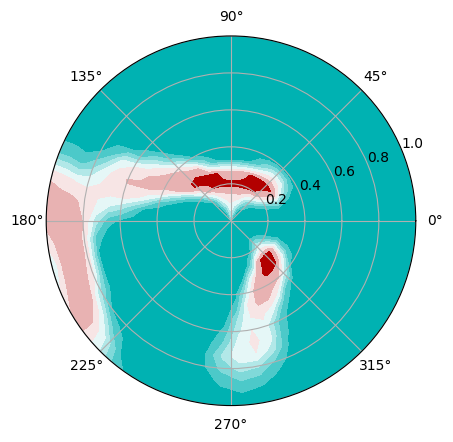

In [ ]:
%matplotlib inline
bvc_rate = dynamics.cache['rates'].bvc
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
theta_bvc, r_bvc = np.meshgrid(
    np.linspace(0, 2 * np.pi, cache.tc_gen.n_bvc_theta),  # Angular dimension
    np.linspace(0, 1, cache.tc_gen.n_bvc_r)  # Radial dimension, adjust as necessary
)


ax.contourf(
    theta_bvc.T,
    r_bvc.T,
    np.reshape(np.maximum(bvc_rate, 1e-7), (tc_gen.n_bvc_theta, tc_gen.n_bvc_r)),
    cmap=cmap,
    vmin=0, vmax=1,
    extend="both"
)

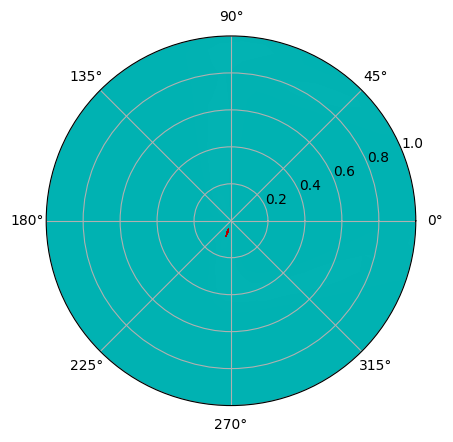

In [ ]:

%matplotlib inline
bvc_rate = weights.bvc.to.h[12][:, None]
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
theta_bvc, r_bvc = np.meshgrid(
    np.linspace(0, 2 * np.pi, cache.tc_gen.n_bvc_theta),  # Angular dimension
    np.linspace(0, 1, cache.tc_gen.n_bvc_r)  # Radial dimension, adjust as necessary
)


ax.contourf(
    theta_bvc.T,
    r_bvc.T,
    np.reshape(np.maximum(bvc_rate, 1e-7), (tc_gen.n_bvc_theta, tc_gen.n_bvc_r)),
    cmap=cmap,
    vmin=0, vmax=1,
    extend="both"
)

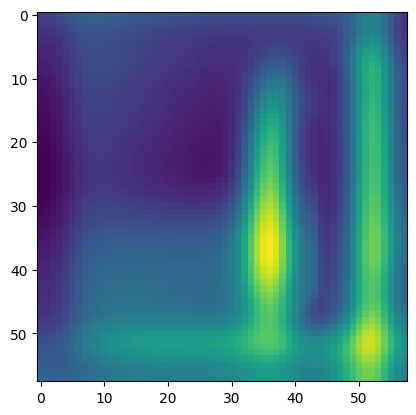

In [ ]:
plt.imshow((weights.bvc.to.h@dynamics.cache['rates'].bvc).reshape(58, 58))

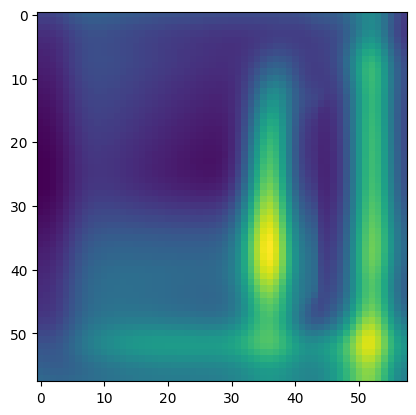

In [ ]:
%matplotlib inline
plt.imshow((weights.bvc.to.h@dynamics.cache['rates'].bvc).reshape(58, 58))

In [ ]:
class MTLGenerator(AbstractGenerator):
    def __init__(
        self,
        r_max: int,
        h_sig: float,
        polar_dist_res: int,
        polar_ang_res: int,
        environment: Environment
    ):
        self.r_max = r_max
        self.h_sig = h_sig
        self.polar_dist_res = polar_dist_res
        self.polar_ang_res = polar_ang_res
        self.environment = environment
        self.res = self.environment.params.res

        self.sigma_th = np.sqrt(0.05)
        self.sigma_r0 = 0.08
        self.alpha_small = 1e-6

    def get_coords(self) -> tuple[Coordinates2D, int, Coordinates2D]:
        coords_x, coords_y = self.environment.params.coords[:, 0], self.environment.params.coords[:, 1]
        min_train_x, max_train_x, min_train_y, max_train_y = min(coords_x), max(coords_x), min(coords_y), max(coords_y)

        n_neurons = Coordinates2D( #  Total H neurons in each dir
            int((max_train_x - min_train_x)/self.res),
            int((max_train_y - min_train_y)/self.res),
        )
        n_neurons_total = n_neurons.x * n_neurons.y #  Total H neurons
        coords = Coordinates2D(*np.meshgrid( # x,y cords for all H neurons
            np.linspace(
                min_train_x, max_train_x, n_neurons.x
            ),
            np.linspace(
                min_train_y, max_train_y, n_neurons.y
            )
        ))

        return coords, n_neurons_total, n_neurons

    def get_bvc_params(self) -> tuple[int, np.ndarray, np.ndarray]:
        n_bvc_r = self.r_max // self.polar_dist_res # Num BVCs along a radius
        n_bvc_theta = int(np.floor( (2*np.pi - 0.01) / self.polar_ang_res ) + 1) # Num BVCs in a ring
        n_bvc = n_bvc_r * n_bvc_theta
        polar_dist = calculate_polar_distance(self.r_max)

        polar_ang = np.arange(0, n_bvc_theta * self.polar_ang_res, self.polar_ang_res)
        p_dist, p_ang = np.meshgrid(polar_dist, polar_ang) #  polar coords of all BVC neurons

        bvc_dist = p_dist.flatten() # Same, but in column vector
        bvc_ang = p_ang.flatten()

        bvc_ang = bvc_ang - 2 * np.pi * (bvc_ang > np.pi) # Make sure angles in correct range

        return n_bvc, bvc_dist, bvc_ang

    def get_perifirical_cells_params(self) -> tuple[int, np.ndarray]:
        n_pr = len(set(wall.polygon.texture.id_ for wall in self.environment.walls)) # One perirhinal neuron for each wall identity/texture (walls only)
        pr_activations = np.eye(n_pr) # identity matrix
        return n_pr, pr_activations

    @staticmethod
    def get_h_sq_distances(coords: Coordinates2D, n_neurons_total: int) -> np.ndarray:
        h_separations = Coordinates2D(
            (np.outer(coords.x, np.ones(n_neurons_total)) - np.outer(coords.x, np.ones(n_neurons_total)).T).T,
            (np.outer(coords.y, np.ones(n_neurons_total)) - np.outer(coords.y, np.ones(n_neurons_total)).T).T
        )

        # Calculate square distances
        h_sq_distances = h_separations.x**2 + h_separations.y**2

        return h_sq_distances

    @staticmethod
    def initialize_h2h_weights(h_sq_distances: np.ndarray, h_sig: float) -> np.ndarray:
        h2h_weights = np.exp(-h_sq_distances / (h_sig**2))
        return h2h_weights

    @staticmethod
    def initialize_pr2pr_weights(n_pr: int) -> np.ndarray:
        # Initialize pr2pr_weights
        return np.zeros((n_pr, n_pr))

    @staticmethod
    def initialize_bvc2bvc_weights(n_bvc: int) -> np.ndarray:
        # Initialize bvc2bvc_weights
        return np.zeros((n_bvc, n_bvc))

    def initialize_auto_weights(
        self,
        h_sq_distances: np.ndarray,
        h_sig: float,
        n_pr: int,
        n_bvc: int
    ):
        return self.initialize_h2h_weights(h_sq_distances, h_sig), self.initialize_pr2pr_weights(n_pr), self.initialize_bvc2bvc_weights(n_bvc)

    def initialize_cross_weights(
        self,
        n_neurons: Coordinates2D,
        n_h_neurons_total: int,
        n_bvc: int,
        n_pr: int,
        coords: Coordinates2D,
        bvc_ang: np.array,
        bvc_dist: np.ndarray,
        pr_activations: np.ndarray
    ) -> tuple[
        np.ndarray,
        np.ndarray,
        np.ndarray,
        np.ndarray,
        np.ndarray,
        np.ndarray,
    ]:
        bvc2h_weights = np.zeros((n_h_neurons_total, n_bvc))
        bvc2pr_weights = np.zeros((n_pr, n_bvc))
        pr2h_weights = np.zeros((n_h_neurons_total, n_pr))
        h2pr_weights = pr2h_weights.T

        for location in range(self.environment.walls[0].visible_parts.shape[0]):
            pos_x = self.environment.params.coords[location, 0]
            pos_y = self.environment.params.coords[location, 1]
            all_visible_parts_x, all_visible_parts_y, all_non_nan_indices, all_boundary_point_texture = list(), list(), list(), list()
            for wall in self.environment.walls:
                visible_parts_x = wall.visible_parts[location, :, 0]
                visible_parts_y = wall.visible_parts[location, :, 1]
                non_nan_indices = np.where(~np.isnan(visible_parts_x))[0]
                boundary_point_texture = wall.polygon.texture.id_*np.ones_like(non_nan_indices)
                all_visible_parts_x.append(visible_parts_x[non_nan_indices])
                all_visible_parts_y.append(visible_parts_y[non_nan_indices])
                all_non_nan_indices.append(non_nan_indices)
                all_boundary_point_texture.append(boundary_point_texture)

            visible_parts_x = np.concatenate(all_visible_parts_x)
            visible_parts_y = np.concatenate(all_visible_parts_y)
            visible_boundary_points = Coordinates2D(
                visible_parts_x - pos_x,
                visible_parts_y - pos_y
            )
            non_nan_indices = np.concatenate(all_non_nan_indices)
            boundary_point_texture = np.concatenate(all_boundary_point_texture)

            boundary_theta, boundary_r = np.arctan2(visible_boundary_points.y, visible_boundary_points.x), np.sqrt(visible_boundary_points.x**2 + visible_boundary_points.y**2)
            boundary_r[boundary_r < self.polar_dist_res] = self.polar_dist_res

            h_activations = np.exp(-((coords.x.reshape((-1, 1)) - pos_x)**2 + (coords.y.reshape((-1, 1)) - pos_y)**2) / (self.h_sig**2))
            bvc_activations = np.zeros(n_bvc)
            bvc2pr_weights_contrib = np.zeros(bvc2pr_weights.shape)
            h2pr_weights_contrib = np.zeros(h2pr_weights.shape)

            for boundary_point in range(visible_boundary_points.x.size):
                delayed_bvc_activations = get_boundary_activations(
                    bvc_ang,
                    boundary_theta[boundary_point] + np.pi/2,
                    bvc_dist,
                    boundary_r[boundary_point],
                    sigma_r0=self.sigma_r0,
                    sigma_th=self.sigma_th,
                    mask=bvc_activations <= 1
                )
                bvc_activations += delayed_bvc_activations
                bvc2pr_weights_contrib += np.outer(pr_activations[:, int(boundary_point_texture[boundary_point]) - 1], delayed_bvc_activations)
                h2pr_weights_contrib += np.outer(pr_activations[:, int(boundary_point_texture[boundary_point]) - 1], h_activations)

            bvc2h_weights_contrib = np.outer(h_activations, bvc_activations)
            bvc2h_weights += bvc2h_weights_contrib
            bvc2pr_weights += bvc2pr_weights_contrib
            h2pr_weights += h2pr_weights_contrib

        # bvc2h_weights = np.reshape(np.transpose(np.reshape(bvc2h_weights, (n_neurons.x, n_neurons.y, n_bvc)), (1, 0, 2)), (n_h_neurons_total, n_bvc))
        bvc2h_weights = np.reshape(np.reshape(np.transpose(np.reshape(bvc2h_weights, (n_neurons.y, n_neurons.x, n_bvc)), (1, 0, 2)), (n_neurons.x, n_neurons.y, n_bvc)), (n_h_neurons_total, n_bvc))

        h2bvc_weights, pr2bvc_weights, pr2h_weights = self.invert_weights(bvc2h_weights, bvc2pr_weights, h2pr_weights)

        # Post-synaptic normalization
        bvc2h_weights, h2bvc_weights, bvc2pr_weights, pr2bvc_weights, h2pr_weights, pr2h_weights = self.normalize_weights(
            bvc2h_weights,
            h2bvc_weights,
            bvc2pr_weights,
            pr2bvc_weights,
            h2pr_weights,
            pr2h_weights
        )

        return bvc2h_weights, bvc2pr_weights, pr2h_weights, h2pr_weights, h2bvc_weights, pr2bvc_weights

    @staticmethod
    def invert_weights(*weights: np.ndarray) -> tuple[np.ndarray, ...]:
        return tuple([weight.T for weight in weights])

    # def normalize_weights(
    #     self,
    #     bvc2h_weights: np.ndarray,
    #     h2bvc_weights: np.ndarray,
    #     bvc2pr_weights: np.ndarray,
    #     pr2bvc_weights: np.ndarray,
    #     h2pr_weights: np.ndarray,
    #     pr2h_weights: np.ndarray
    # ) -> tuple[
    #     np.ndarray,
    #     np.ndarray,
    #     np.ndarray,
    #     np.ndarray,
    #     np.ndarray,
    #     np.ndarray
    # ]:
    #     # FIXME: In the future can be refactored, now made to be consistent with legacy code
    #     bvc2h_weights = bvc2h_weights / (np.sum(bvc2h_weights, axis=1, keepdims=True) + self.alpha_small)
    #     h2bvc_weights = h2bvc_weights / (np.sum(h2bvc_weights, axis=1, keepdims=True) + self.alpha_small)

    #     bvc2pr_weights = bvc2pr_weights / (np.sum(bvc2pr_weights, axis=1, keepdims=True) + self.alpha_small)
    #     pr2bvc_weights = pr2bvc_weights / (np.sum(pr2bvc_weights, axis=1, keepdims=True)  + self.alpha_small)
    #     h2pr_weights = h2pr_weights / (np.sum(h2pr_weights, axis=1, keepdims=True) + self.alpha_small)
    #     pr2h_weights = pr2h_weights / (np.sum(pr2h_weights, axis=1, keepdims=True)  + self.alpha_small)

    #     return bvc2h_weights, h2bvc_weights, bvc2pr_weights, pr2bvc_weights, h2pr_weights, pr2h_weights
    def normalize_weights(
        self,
        bvc2h_weights: np.ndarray,
        h2bvc_weights: np.ndarray,
        bvc2pr_weights: np.ndarray,
        pr2bvc_weights: np.ndarray,
        h2pr_weights: np.ndarray,
        pr2h_weights: np.ndarray
    ) -> tuple[
        np.ndarray,
        np.ndarray,
        np.ndarray,
        np.ndarray,
        np.ndarray,
        np.ndarray
    ]:
        # FIXME: In the future can be refactored, now made to be consistent with legacy code
        bvc2h_weights = bvc2h_weights / (np.sum(bvc2h_weights, axis=0, keepdims=True) + self.alpha_small)
        h2bvc_weights = h2bvc_weights / (np.sum(h2bvc_weights, axis=0, keepdims=True) + self.alpha_small)

        bvc2pr_weights = bvc2pr_weights / (np.sum(bvc2pr_weights, axis=0, keepdims=True) + self.alpha_small)
        pr2bvc_weights = pr2bvc_weights / (np.sum(pr2bvc_weights, axis=0, keepdims=True)  + self.alpha_small)
        h2pr_weights = h2pr_weights / (np.sum(h2pr_weights, axis=0, keepdims=True) + self.alpha_small)
        pr2h_weights = pr2h_weights / (np.sum(pr2h_weights, axis=0, keepdims=True)  + self.alpha_small)

        return bvc2h_weights, h2bvc_weights, bvc2pr_weights, pr2bvc_weights, h2pr_weights, pr2h_weights

    def generate(self):
        coords, n_neurons_total, n_neurons = self.get_coords()
        n_bvc, bvc_dist, bvc_ang = self.get_bvc_params()
        n_pr, pr_activations = self.get_perifirical_cells_params()
        h_sq_distances = self.get_h_sq_distances(coords, n_neurons_total)
        h2h_weights, pr2pr_weights, bvc2bvc_weights = self.initialize_auto_weights(h_sq_distances, self.h_sig, n_pr, n_bvc)

        h2h_weights = np.reshape(np.transpose(np.reshape(h2h_weights, (n_neurons.y, n_neurons.x, n_neurons.y, n_neurons.x)),  (1, 0, 3, 2)), h2h_weights.shape)

        bvc2h_weights, bvc2pr_weights, pr2h_weights, h2pr_weights, h2bvc_weights, pr2bvc_weights = self.initialize_cross_weights(
            n_neurons,
            n_neurons_total,
            n_bvc,
            n_pr,
            coords,
            bvc_ang,
            bvc_dist,
            pr_activations
        )
        weights = DirectedTensorGroup(
            DirectedTensor(
                from_ = 'h',
                to = 'h',
                weights = h2h_weights
            ),
            DirectedTensor(
                from_ = 'h',
                to = 'pr',
                weights = h2pr_weights
            ),
            DirectedTensor(
                from_ = 'h',
                to = 'bvc',
                weights = h2bvc_weights
            ),
            DirectedTensor(
                from_ = 'pr',
                to = 'h',
                weights = pr2h_weights
            ),
            DirectedTensor(
                from_ = 'pr',
                to = 'pr',
                weights = pr2pr_weights
            ),
            DirectedTensor(
                from_ = 'pr',
                to = 'bvc',
                weights = pr2bvc_weights
            ),
            DirectedTensor(
                from_ = 'bvc',
                to = 'h',
                weights = bvc2h_weights
            ),
            DirectedTensor(
                from_ = 'bvc',
                to = 'pr',
                weights = bvc2pr_weights
            ),
            DirectedTensor(
                from_ = 'bvc',
                to = 'bvc',
                weights = bvc2bvc_weights
            ),
        )

        return weights

In [ ]:
mtl_cfg = '../cfg/cells/mtl_cells.ini'
config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
config.read(mtl_cfg)

space_section = config['Space']
res = space_section.eval('res')
r_max = space_section.eval('r_max')

polargrid_section = config['PolarGrid']
polar_dist_res = polargrid_section.eval('polar_dist_res')
polar_ang_res = polargrid_section.eval('polar_ang_res', locals=dict(pi=np.pi))
h_sig = polargrid_section.eval('sigma_hill')


gen = MTLGenerator(
    r_max, h_sig, polar_dist_res, polar_ang_res, env
)
# gen.save('../data/generators/mtl_gen.pkl')
mtl_weights = gen.generate()

NameError: name 'MTLGenerator' is not defined

In [ ]:
n_h_neurons_total = len(cache.rates.h)
n_h_neurons_total

3364

RuntimeError: No active exception to reraise

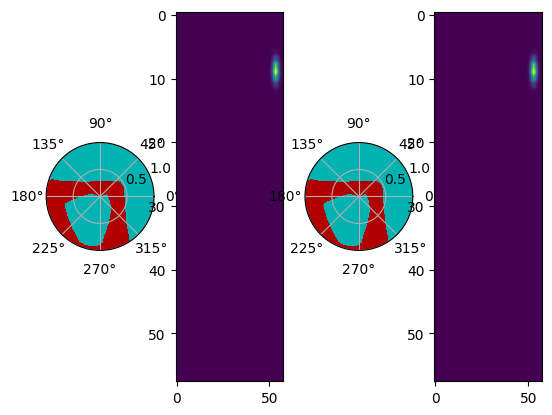

In [ ]:
%matplotlib inline

bvc_contribs, h_contribs = list(), list()

sigma_th = np.sqrt(0.05)
sigma_r0 = 0.08

theta_bvc, r_bvc = np.meshgrid(
    np.linspace(0, 2 * np.pi, cache.tc_gen.n_bvc_theta),  # Angular dimension
    np.linspace(0, 1, cache.tc_gen.n_bvc_r)  # Radial dimension, adjust as necessary
)

n_bvc = len(cache.rates.bvc)
n_h_neurons_total = len(cache.rates.h)

n_neurons = Coordinates2D(
    np.sqrt(n_h_neurons_total).astype(int),
    np.sqrt(n_h_neurons_total).astype(int)
)

environment = env
coords_x, coords_y = environment.params.coords[:, 0], environment.params.coords[:, 1]
min_train_x, max_train_x, min_train_y, max_train_y = min(coords_x), max(coords_x), min(coords_y), max(coords_y)

n_neurons = Coordinates2D( #  Total H neurons in each dir
    int((max_train_x - min_train_x)/env.params.res),
    int((max_train_y - min_train_y)/env.params.res),
)
n_neurons_total = n_neurons.x * n_neurons.y #  Total H neurons
coords = Coordinates2D(*np.meshgrid( # x,y cords for all H neurons
    np.linspace(
        min_train_x, max_train_x, n_neurons.x
    ),
    np.linspace(
        min_train_y, max_train_y, n_neurons.y
    )
))

n_bvc_r = r_max // polar_dist_res # Num BVCs along a radius
n_bvc_theta = int(np.floor( (2*np.pi - 0.01) / polar_ang_res ) + 1) # Num BVCs in a ring
n_bvc = n_bvc_r * n_bvc_theta
polar_dist = calculate_polar_distance(r_max)

polar_ang = np.arange(0, n_bvc_theta * polar_ang_res, polar_ang_res)
p_dist, p_ang = np.meshgrid(polar_dist, polar_ang) #  polar coords of all BVC neurons

bvc_dist = p_dist.flatten() # Same, but in column vector
bvc_ang = p_ang.flatten()

bvc_ang = bvc_ang - 2 * np.pi * (bvc_ang > np.pi) # Make sure angles in correct range

bvc2h_weights = np.zeros((n_h_neurons_total, n_bvc))

for location in range(env.walls[0].visible_parts.shape[0]):
    location = 2961
    pos_x = env.params.coords[location, 0]
    pos_y = env.params.coords[location, 1]
    all_visible_parts_x, all_visible_parts_y, all_non_nan_indices, all_boundary_point_texture = list(), list(), list(), list()
    for wall in env.walls:
        visible_parts_x = wall.visible_parts[location, :, 0]
        visible_parts_y = wall.visible_parts[location, :, 1]
        non_nan_indices = np.where(~np.isnan(visible_parts_x))[0]
        boundary_point_texture = wall.polygon.texture.id_*np.ones_like(non_nan_indices)
        all_visible_parts_x.append(visible_parts_x[non_nan_indices])
        all_visible_parts_y.append(visible_parts_y[non_nan_indices])
        all_non_nan_indices.append(non_nan_indices)
        all_boundary_point_texture.append(boundary_point_texture)

    visible_parts_x = np.concatenate(all_visible_parts_x)
    visible_parts_y = np.concatenate(all_visible_parts_y)
    visible_boundary_points = Coordinates2D(
        visible_parts_x - pos_x,
        visible_parts_y - pos_y
    )
    non_nan_indices = np.concatenate(all_non_nan_indices)
    boundary_point_texture = np.concatenate(all_boundary_point_texture)

    boundary_theta, boundary_r = np.arctan2(visible_boundary_points.y, visible_boundary_points.x), np.sqrt(visible_boundary_points.x**2 + visible_boundary_points.y**2)
    boundary_r[boundary_r < polar_dist_res] = polar_dist_res

    h_activations = np.exp(-((coords.x.reshape((-1, 1)) - pos_x)**2 + (coords.y.reshape((-1, 1)) - pos_y)**2) / (h_sig**2))
    bvc_activations = np.zeros(n_bvc)

    for boundary_point in range(visible_boundary_points.x.size):
        delayed_bvc_activations = get_boundary_activations(
            bvc_ang,
            boundary_theta[boundary_point] + np.pi/2,
            bvc_dist,
            boundary_r[boundary_point],
            sigma_r0=sigma_r0,
            sigma_th=sigma_th,
            mask=bvc_activations <= 1
        )
        bvc_activations += delayed_bvc_activations

    bvc2h_weights_contrib = np.outer(h_activations, bvc_activations)
    bvc_contribs.append(bvc_activations)
    h_contribs.append(h_activations)
    bvc2h_weights += bvc2h_weights_contrib

    fig = plt.figure()
    ax1 = fig.add_subplot(141, projection='polar')
    ax2 = fig.add_subplot(142)
    ax3 = fig.add_subplot(143, projection='polar')
    ax4 = fig.add_subplot(144)

    ax1.contourf(
        theta_bvc.T,
        r_bvc.T,
        np.reshape(bvc2h_weights_contrib.T@h_activations, (tc_gen.n_bvc_theta, tc_gen.n_bvc_r)),
        cmap=cmap,
        vmin=0, vmax=1,
        extend="both"
    )

    ax2.imshow(
        (bvc2h_weights_contrib@bvc_activations).reshape(58, 58),
        aspect='auto'
    )

    ax3.contourf(
        theta_bvc.T,
        r_bvc.T,
        np.reshape(bvc2h_weights.T@h_activations, (tc_gen.n_bvc_theta, tc_gen.n_bvc_r)),
        cmap=cmap,
        vmin=0, vmax=1,
        extend="both"
    )

    ax4.imshow(
        (bvc2h_weights@bvc_activations).reshape(58, 58),
        aspect='auto'
    )
    raise
    # fig.savefig(f'../tmp/frame_{location}.png')
    # plt.close(fig)

# bvc2h_weights = np.reshape(np.transpose(np.reshape(bvc2h_weights, (n_neurons.x, n_neurons.y, n_bvc)), (1, 0, 2)), (n_h_neurons_total, n_bvc))
bvc2h_weights_reshaped = np.reshape(np.reshape(np.transpose(np.reshape(bvc2h_weights, (n_neurons.y, n_neurons.x, n_bvc)), (1, 0, 2)), (n_neurons.x, n_neurons.y, n_bvc)), (n_h_neurons_total, n_bvc))

h2bvc_weights = bvc2h_weights.T

h2bvc_weights_reshaped = bvc2h_weights_reshaped.T


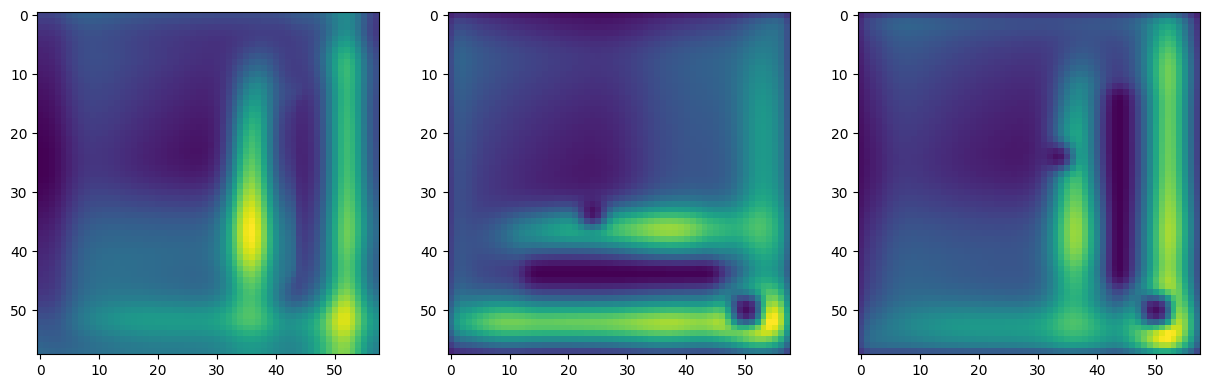

In [ ]:
%matplotlib inline
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.imshow((weights.bvc.to.h@dynamics.cache['rates'].bvc).reshape(58, 58))
ax2.imshow((bvc2h_weights@dynamics.cache['rates'].bvc).reshape(58, 58))
ax3.imshow((bvc2h_weights_reshaped@dynamics.cache['rates'].bvc).reshape(58, 58))


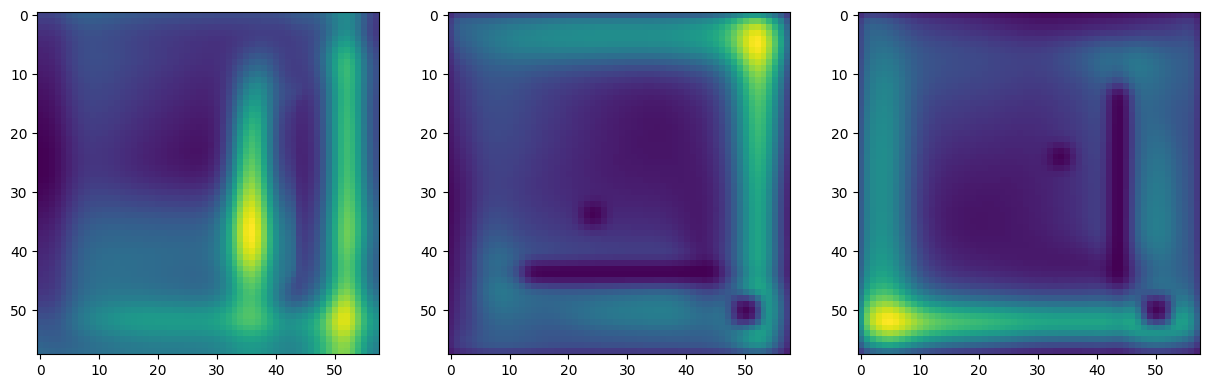

In [ ]:
%matplotlib inline
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.imshow((weights.bvc.to.h@dynamics.cache['rates'].bvc).reshape(58, 58))
ax2.imshow((bvc2h_weights@dynamics.cache['rates'].bvc).reshape(58, 58))
ax3.imshow((bvc2h_weights_reshaped@dynamics.cache['rates'].bvc).reshape(58, 58))


In [ ]:
bvc2h_weights

array([[3.86967765e+00, 4.21073793e+00, 3.36450129e+00, ...,
        2.66754762e+00, 2.54719880e+00, 2.74360370e+00],
       [4.99738287e+00, 5.47782829e+00, 4.46085333e+00, ...,
        3.62007205e+00, 3.47457279e+00, 3.79214699e+00],
       [4.66010887e+00, 5.23669188e+00, 4.53181589e+00, ...,
        3.93614391e+00, 3.81250718e+00, 4.22700466e+00],
       ...,
       [6.52672011e+00, 6.26074207e+00, 4.44709568e+00, ...,
        8.30434203e-16, 3.53030896e-16, 1.76826327e-16],
       [5.69736691e+00, 5.15228280e+00, 3.22100844e+00, ...,
        2.00031422e-16, 1.00377824e-16, 5.74876039e-17],
       [4.01285407e+00, 3.52957650e+00, 2.08286141e+00, ...,
        4.71970565e-17, 2.77558400e-17, 1.80172102e-17]])

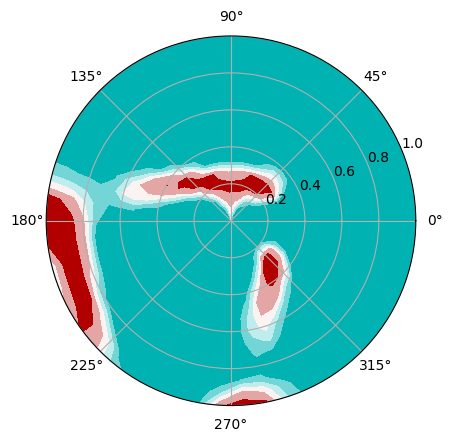

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='polar')

ax1.contourf(
        theta_bvc.T,
        r_bvc.T,
        np.reshape((dynamics.cache['rates'].bvc), (tc_gen.n_bvc_theta, tc_gen.n_bvc_r)),
        cmap=cmap,
        vmin=0, vmax=1,
        extend="both"
    )

In [ ]:
position = None
location_ = None

for location in range(env.walls[0].visible_parts.shape[0]):
    pos_x = env.params.coords[location, 0]
    pos_y = env.params.coords[location, 1]
    # if np.isclose(pos_x, 7, atol=.3) and np.isclose(pos_y, -7, atol=.3):
    if location_ is None:
        location_ = location
        position = (pos_x, pos_y)
    else:
        # compare distance between current location and (7, -7) and previous location and (7, -7)
        if np.sqrt((pos_x - 7)**2 + (pos_y + 7)**2) < np.sqrt((position[0] - 7)**2 + (position[1] + 7)**2):
            location_ = location
            position = (pos_x, pos_y)
print(position, location_)
        # break

(7.100000000000038, -6.999999999999988) 2961


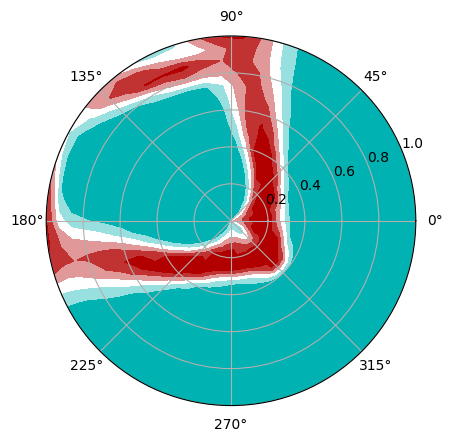

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='polar')

ax1.contourf(
        theta_bvc.T,
        r_bvc.T,
        # np.reshape((bvc_contribs[location_]).T, (tc_gen.n_bvc_theta, tc_gen.n_bvc_r)),
        np.reshape((bvc_contribs[location_]).T, (tc_gen.n_bvc_theta, tc_gen.n_bvc_r)),
        cmap=cmap,
        vmin=0, vmax=1,
        extend="both"
    )

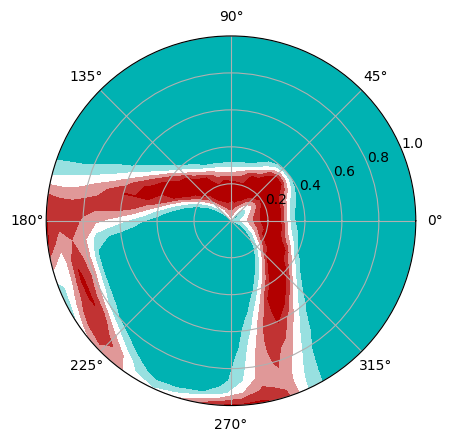

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='polar')

ax1.contourf(
        theta_bvc.T,
        r_bvc.T,
        # np.reshape((bvc_contribs[location_]).T, (tc_gen.n_bvc_theta, tc_gen.n_bvc_r)),
        np.reshape((bvc_contribs[location_]).T, (tc_gen.n_bvc_theta, tc_gen.n_bvc_r)),
        cmap=cmap,
        vmin=0, vmax=1,
        extend="both"
    )

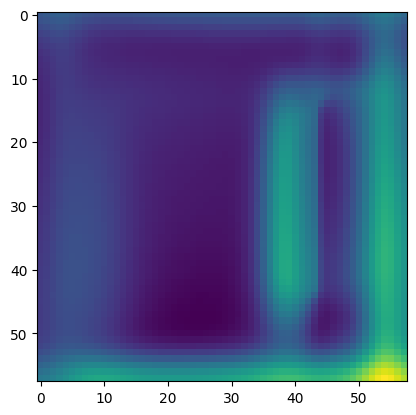

In [ ]:
for i, bvc in enumerate(bvc_contribs):
    if not i%10:
        plt.imshow((weights.bvc.to.h@bvc).reshape(58, 58))
        # plt.imshow((bvc2h_weights_reshaped@bvc).reshape(58, 58))
        # plt.imshow((bvc2h_weights@bvc).reshape(58, 58))
        plt.savefig(f'../tmp/frame_{i}.png')

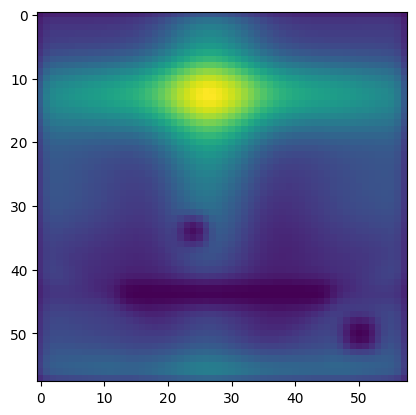

In [ ]:
plt.imshow((bvc2h_weights@bvc_contribs[59*26]).reshape(58, 58))

In [ ]:
bvc2h_weights.shape, h_act.shape

((3364, 816), (3364, 1))

RuntimeError: No active exception to reraise

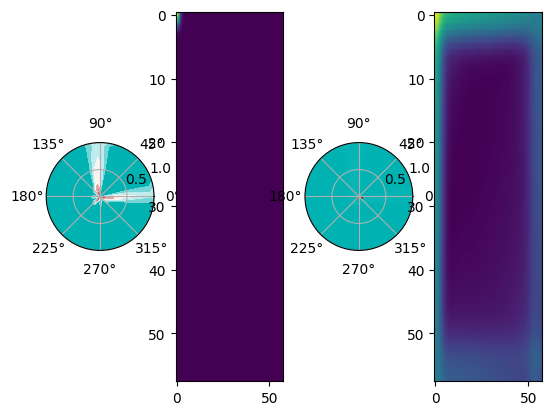

In [ ]:
bvc2h_weights = weights.bvc.to.h

for h_act, bvc_act in zip(h_contribs, bvc_contribs):
    bvc_act = (bvc_act - bvc_act.min())/(bvc_act.max() - bvc_act.min())
    fig = plt.figure()
    ax1 = fig.add_subplot(141, projection='polar')
    ax2 = fig.add_subplot(142)
    ax3 = fig.add_subplot(143, projection='polar')
    ax4 = fig.add_subplot(144)

    ax1.contourf(
        theta_bvc.T,
        r_bvc.T,
        np.reshape(np.maximum(bvc_act, 1e-7), (tc_gen.n_bvc_theta, tc_gen.n_bvc_r)),
        cmap=cmap,
        vmin=0, vmax=1,
        extend="both"
    )

    ax2.imshow(h_act.reshape(58, 58), aspect='auto')

    ax3.contourf(
        theta_bvc.T,
        r_bvc.T,
        np.reshape((h_act.T@bvc2h_weights).T, (tc_gen.n_bvc_theta, tc_gen.n_bvc_r)),
        cmap=cmap,
        vmin=0, vmax=1,
        extend="both"
    )

    ax4.imshow(
        (bvc2h_weights@bvc_act).reshape(58, 58),
        aspect='auto'
    )
    raise


In [ ]:
bvc2h_weights = weights.bvc.to.h

for i, (h_act, bvc_act) in enumerate(zip(h_contribs, bvc_contribs)):
    if not i%100:
        fig = plt.figure()
        ax1 = fig.add_subplot(141, projection='polar')
        ax2 = fig.add_subplot(142)
        ax3 = fig.add_subplot(143, projection='polar')
        ax4 = fig.add_subplot(144)

        ax1.contourf(
            theta_bvc.T,
            r_bvc.T,
            np.reshape(np.maximum(bvc_act, 1e-7), (tc_gen.n_bvc_theta, tc_gen.n_bvc_r)),
            cmap=cmap,
            vmin=0, vmax=1,
            extend="both"
        )

        ax2.imshow(h_act.reshape(58, 58), aspect='auto')

        ax3.contourf(
            theta_bvc.T,
            r_bvc.T,
            np.reshape(bvc2h_weights.T@h_act, (tc_gen.n_bvc_theta, tc_gen.n_bvc_r)),
            cmap=cmap,
            vmin=0, vmax=1,
            extend="both"
        )

        ax4.imshow(
            (bvc2h_weights@bvc_act).reshape(58, 58),
            aspect='auto'
        )
        fig.savefig(f'../tmp/frame_{i}.png')
        plt.close(fig)


In [ ]:
from bbtoolkit.utils.viz.video import make_video_from_images


image_directory = '../tmp'
video_save_path = '../data/videos/debug_h_inserted(8).mp4'
make_video_from_images(image_directory, video_save_path, 2)

In [ ]:
from bbtoolkit.utils.datautils import remove_files_from_dir

remove_files_from_dir('../tmp')